## Импортируем необходимые бибилиотеки

In [17]:
import pandas as pd
import sqlite3

## Создадим подключение к базе данных

In [18]:
conn = sqlite3.connect("../data/checking-logs.sqlite")

## Сделаем запрос к базе данных

In [ ]:
query = """
SELECT timestamp
FROM checker
WHERE checker.uid LIKE 'user_%';
"""
df = pd.read_sql_query(query, conn, parse_dates=["timestamp"])

## Извлечем день недели, день и час коммита

In [ ]:
df["weekday"] = df["timestamp"].dt.dayofweek
df["day"] = df.timestamp.dt.day
df["hour"] = df.timestamp.dt.hour
df

,timestamp,weekday,day,hour
0,2020-04-17 05:19:02.744528,4,17,5
1,2020-04-17 05:22:35.249331,4,17,5
2,2020-04-17 05:22:45.549397,4,17,5
3,2020-04-17 05:34:14.691200,4,17,5
4,2020-04-17 05:34:24.422370,4,17,5
...,...,...,...,...
3202,2020-05-21 20:19:06.872761,3,21,20
3203,2020-05-21 20:22:41.785725,3,21,20
3204,2020-05-21 20:22:41.877806,3,21,20
3205,2020-05-21 20:37:00.129678,3,21,20


## Определим какой это день: рабочий день или выходной

In [20]:
df["type"] = df["weekday"].apply(lambda x: "working_day" if x < 5 else "weekend")
df.head()

,timestamp,weekday,day,hour,type
0,2020-04-17 05:19:02.744528,4,17,5,working_day
1,2020-04-17 05:22:35.249331,4,17,5,working_day
2,2020-04-17 05:22:45.549397,4,17,5,working_day
3,2020-04-17 05:34:14.691200,4,17,5,working_day
4,2020-04-17 05:34:24.422370,4,17,5,working_day


## Сгруппируем по типу дня недели, затем по дням, а затем по часам и посчитаем количество коммитов

In [41]:
grouped_df = df.groupby([ "type", "day", "hour"]).count()
grouped_df = grouped_df.drop(columns='timestamp')
grouped_df.head(20)

weekday
type    day hour         
weekend 2   7           3
            8           1
            9           2
            10          1
            11         84
            12         19
            13         26
            14         28
            15         18
            16         24
            17          2
            19         10
            20          8
            23         16
        3   8          13
            9          11
            10         10
            11         13
            12         14
            13         19

## Найдём среднее количество коммитов в каждый час отдельно для рабочего и выходного дня

In [42]:
grouped_df = grouped_df.groupby(['type', 'hour']).mean()
grouped_df

weekday
type        hour           
weekend     0      2.000000
            1      6.000000
            3      1.000000
            5      2.000000
            7      4.000000
            8      7.000000
            9      3.666667
            10     7.000000
            11    23.600000
            12     9.500000
            13    18.000000
            14    12.428571
            15    14.250000
            16    14.800000
            17     7.142857
            18     9.714286
            19    13.125000
            20    13.000000
            21    10.285714
            22     9.833333
            23     6.400000
working_day 0      3.000000
            3      2.000000
            5      7.500000
            6      1.500000
            7      5.166667
            8      3.700000
            9      6.000000
            10    13.200000
            11     6.769231
            12     7.181818
            13     8.111111
            14    11.090909
            15    14.100000
            16    18.888889
            17    17.454545
            18    16.700000
            19    19.454545
            20    15.250000
            21    24.333333
            22     3.750000
            23     5.000000

## Создадим итоговый датафрейм, на основе которого будет строится график

In [ ]:
res_df = grouped_df.pivot_table(index='hour', columns='type', values='weekday')
new_rows = {2: [None, None], 4: [None, None]} # Создаём строки с недостающими часами
res_df = pd.concat([res_df, pd.DataFrame.from_dict(new_rows, orient='index', columns=res_df.columns)]) # Добавляем эти строки в конец датафрейма
res_df = res_df.sort_index() # Сортируем часы
res_df.index.names = ['hour']
res_df

type,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,NaN
2,NaN,NaN
3,1.000000,2.000000
4,NaN,NaN
5,2.000000,7.500000
6,NaN,1.500000
7,4.000000,5.166667
8,7.000000,3.700000


## Построим график

array([<Axes: title={'center': 'weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

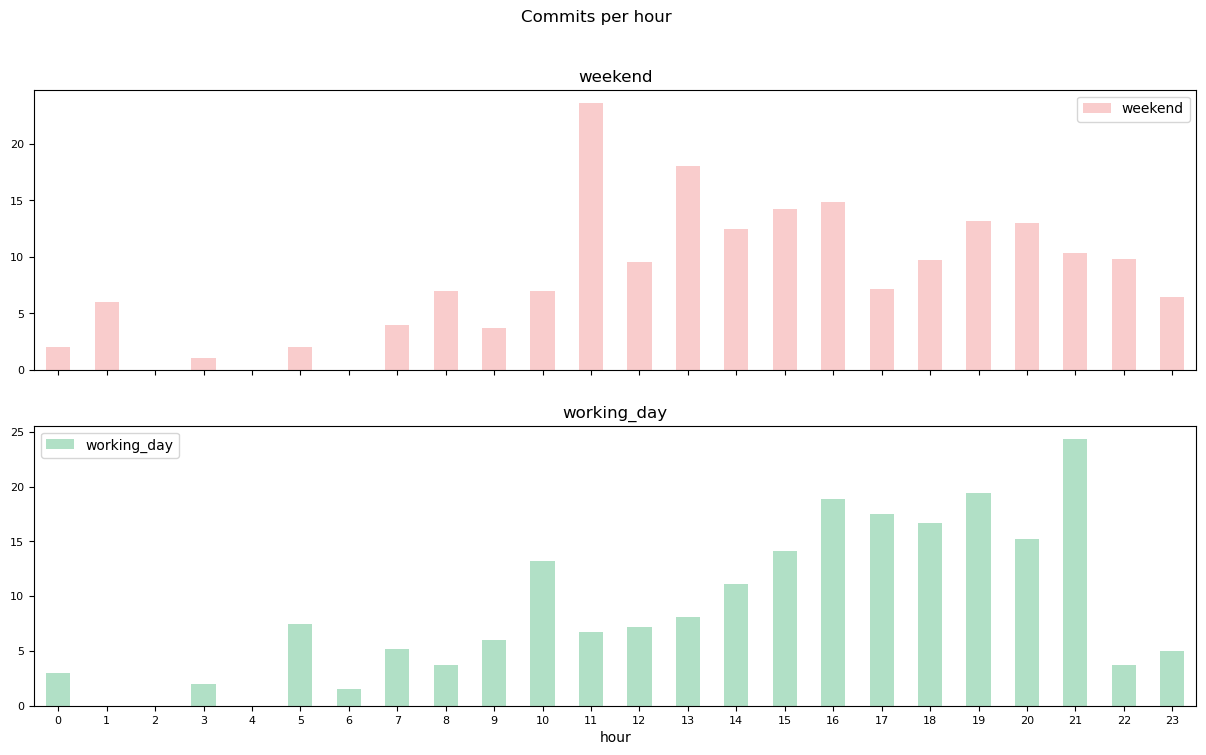

In [73]:
res_df.plot.bar(
    figsize=(15, 8),
    fontsize=8,
    title="Commits per hour",
    rot=0,
    alpha=0.4,
    stacked=True,
    color=['lightcoral', 'mediumseagreen'],
    subplots=True)


## Отличается ли динамика в рабочие дни и выходные?

In [74]:
max_week = res_df['weekend'].max()
res_df[res_df['weekend'] == max_week]

type,weekend,working_day
hour,,
11,23.6,6.769231


**Вывод**: на выходных больше всего коммитов в 11 утра

In [75]:
max_work = res_df['working_day'].max()
res_df[res_df['working_day'] == max_work]

type,weekend,working_day
hour,,
21,10.285714,24.333333


**Вывод**: в будние дни больше всего коммитов в 21 час ночи

## Подведем итоги
Динамика в будние и выходные дни **отличается**: в будние дни она смещена на вечер - ночь, а в выходные на утро.

## Закроем подключение к базе данных

In [ ]:
conn.close()